# Single Product Example 
The basic idea is from the model setting introduced in section 3.2.1. in the paper.<br>
Disclaimer: I may not fully understand the algorithm. For details, read the original paper $\href{https://www.hbs.edu/ris/Publication%20Files/Thompson%20Sampling%20paper_7.13.18_142bf3ec-4925-4ca9-9e90-9aba05ffdef6.pdf}{here}$.

## Notations
* $N$ products
* $M$ resources
* $T$ periods
* Initial inventory $I_j$ for each $j \in [M]$
* Inventory at the end of period $t$ is denoted as $I_j(t)$

## Problem Description
* A retailor offers a price, $p_i \in \mathbf{R}^N$ -- this is our optimization variable.
    * A price vector is chosen from a finite ($K$) set of vectors: $p_i \in \{p_1, \cdots, p_K\}$ and $p_i = (p_{1,i}, \cdots p_{N,i})$
    * We also have a "shut-off" price $p_{\infty}$ which induces a zero-demand for all products.
    * The price chosen at period $t$ is denoted as $P(t) \in \{p_1, \cdots, p_K, p_{\infty}\}$, which has entries $P(t)=(P_1(t), \cdots, P_N(t))$.
* Customers make purchase decisions.
    * Demand of each product at period $t$ is $D(t) = (D_1(t), \cdots, D_N(t))$.
    * Given P(t), the demand $D(t)$ is sampled from a distribution with CDF of the form $F(x_1, \cdots, x_N|P(t), \theta)$ where $\theta \in \Theta \subset \mathbf{R}^l$
* The revenue is realized.
    * Case 1: If there is enough inventory to satisfy demands, the revenue is 
    $$\sum_{i=1}^N D_i(t)P_i(t)$$
    * Case 2: Otherwise, let $\tilde{D}_i(t)$ be the demand satisfied for product $i$. Then, the revenue is given by 
    $$\sum_{i=1}^N \tilde{D}_i(t)P_i(t)$$
    with 
    $$0 \leq \tilde{D}_i(t) \leq D_i(t) \quad \forall i \in [N] \\ 
      I_j = I_j(t-1) - \sum_{i=1}^N \tilde{D}_i(t) a_{i,j} \geq 0 \quad \forall j \in [M] \\
      I_{j'}(t) = 0 \quad \exists j' \in [M]$$
    where $a_{i,j}$ denotes the $j$-th resource needed to make one unit of $i$-th product.

## Fixed Inventory Constraints
Firstly, we consider the case where the inventory capacity is fixed in each period.
* For each period, the resource cannot exceed $c_j = \frac{I_j}{T}$.
* Denote "mean demand" by $d$, the mean demand under the true parameter $\theta$.

## TS-Fixed Algorithm
For $t = 1, \cdots, T$:
* Sample demand: <br>
    Sample a random parameter $\theta(t) \in \Theta$ according to the posterior distribution of $\theta$ given history $\mathcal{H}_{t-1}$. <br>
    Let the mean demand under $\theta(t)$ be $d(t) = \{d_{i,k}\}_{i \in [N], k \in [K]}$.
* Optimize prices by solving the following linear programming $LP(d(t))$:
    $$ \begin{align} \text{maximize} & \quad \sum_{k=1}^K \left(\sum_{i=1}^N p_{i,k} d_{i,k} \right)x_k \\
      \text{subject to} & \quad \sum_{k=1}^K \left(\sum_{i=1}^N a_{i,j} d_{i,k}(t) \right) x_k \leq c_j \\
      & \quad \sum_{k=1}^K x_k \leq 1 \\
      & \quad x_k \geq 0 \end{align}$$
    Let $x(t) = (x_1(t), \cdots, x_k(t))$ be the optimal solution.
* Offer price: <br>
    Offer $P(t)=p_k$ with probability $x_k$, and choose $p_{\infty}$ with probability $1-\sum_{k=1}^K x_k$.
* Update parameters: <br>
    Observe demand $D(t)$, update the history $\mathcal{H}_t = \mathcal{H}_{t-1} \cup \{P(t), D(t)\}$ and the posterior distribution of $\theta$ given $\mathcal{H}_t$.

## Bernoulli Demand
Assume, for all prices, the demand for each product is Bernoulli distributed and use a beta posterior for each $\theta$. Then, the prior distribution of mean demand $d_{i,k}$ is uniform in $[0,1]$, which is equivalent to $Beta(1,1)$. <br>
Let $N_k(t-1)$ be the number of time periods that the retailor has offered price $p_k$ in the first $t-1$ periods, and $W_{i,k}(t-1)$ be the number of product $i$ that is purchased under price $p_k$ during these periods. <br>
As a consequence, the posterior distribution of $d_{i,k}$ is $Beta(W_{i,k}(t-1)+1, N_k(t-1) - W_{i,k}(t-1) + 1)$. Also, the parameters update is done by $N_{k}(t) \leftarrow N_{k}(t-1) + 1$ and $W_{i,k}(t) \leftarrow W_{i,k}(t-1) + D_i(t)$.

## Inventory Constraint Updating and TS-update Algorithm
Let $I_j(t)$ be the inventory level of resource $j$ at the end of period $t$. Instead of fixed resource availability, we can update it by the average inventory for resources available from period $t$ to $T$ as 
$$c_j(t) = \frac{I_j(t-1)}{T-t+1}$$

In [1]:
# Import the libraries.
import numpy as np
import matplotlib.pyplot as plt
# Use CVXPY for solving linear programming.
import cvxpy as cp
from scipy.stats import beta
from tqdm.notebook import tqdm

In [2]:
# The set of feasible prices.
price = np.array([29.9, 34.9, 39.9, 44.9])
# The mean demand.
mean_demand = np.array([0.8, 0.6, 0.3, 0.1])
# As the product itself is the resource, we set a as all ones.
a = np.array([1.0, 1.0, 1.0, 1.0])

In [3]:
# The solver for the linear programming.
def LPSolver(price, demand, a, c):
    x = cp.Variable(len(price))
    objective = cp.Maximize(cp.sum(cp.multiply(cp.multiply(price, demand), x)))
    constraints = [cp.sum(cp.multiply(cp.multiply(a, demand), x)) <= c, 
                   cp.sum(x) <= 1, 
                   x >= 0]
    profit = cp.Problem(objective, constraints).solve()
    # 1 - sum(x.value) corresponds to the probability of choosing the shut off price.
    return profit, np.append(x.value, (1 - sum(x.value)))

The paper says when $I=0.25T$, the optimal mixed strategy is to offer the product at \\$39.90 to 75\% of customers and \\$44.90 to 25\% of customers. If $I=0.5T$, the optimal mixed strategy is to offer at \\$34.90 to 66.6\% of customers and at \\$39.90 to 33.3\% of customers. <br>
Let $\alpha = \frac{I}{T}$. Check the optimal mixed strategy as the sanity check.

In [4]:
alpha = 0.25
profit, x = LPSolver(price, mean_demand, a, alpha)
x_disp = np.array2string(x, precision=3, suppress_small=True, floatmode='fixed')
print(f"With alpha = {alpha:.2f}, the optimal allocation is {x_disp}")

alpha = 0.5
_, x = LPSolver(price, mean_demand, a, alpha)
x_disp = np.array2string(x, precision=3, suppress_small=True, floatmode='fixed')
print(f"With alpha = {alpha:.2f}, the optimal allocation is {x_disp}")

With alpha = 0.25, the optimal allocation is [-0.000  0.000  0.750  0.250  0.000]
With alpha = 0.50, the optimal allocation is [0.000 0.667 0.333 0.000 0.000]


In [5]:
# Assume the observed demand is drawn from the normal distribution though the paper doesn't mention about it.
# sigma is used to generate the normal distribution.
sigma = np.array([0.1, 0.05, 0.1, 0.05])
alpha = 0.25

In [6]:
# Let's run the simulation!
# TS-fixed.

# Keep N and W values to produce the Beta distribution, which are initialized to 0.
N_fixed = np.zeros(4)
W_fixed = np.zeros(4)

N_store, W_store = [], []

hist_fixed = {"revenue": [], "price": [], "demand": [], "prob": [], "demand_estimate": []}
# Set T = 10000.
num_iter = 10000

for i in tqdm(range(num_iter)):
    
    # Sample the estimated demand using Beta distribution.
    demand = np.zeros(4)
    for j in range(4):
        demand[j] = beta.ppf(np.random.uniform(), W_fixed[j]+1, N_fixed[j]-W_fixed[j]+1)
        
    # Solve the linear programming.
    _, x = LPSolver(price, demand, a, alpha)
    
    # Choose a price to offer according to x.
    x_cum = np.cumsum(x)
    rand = np.random.uniform()
    choice = -1
    for j in range(len(x)):
        if rand < x_cum[j]:
            choice = j
            break
            
    # Observe the actual demand and compute the revenue realized.
    if choice == len(x) - 1:
        D = 0
        R = 0
    else:
        D = np.clip(np.random.normal(mean_demand[choice], sigma[choice]), a_min=0.0, a_max=1.0)
        # Take minimum to consider the resource (inventory) constraint.
        R = min(a[choice]*D, alpha) * price[choice]
        # Update the parameters.
        N_fixed[choice] += 1
        W_fixed[choice] += D
    
    # Store the variables.
    hist_fixed["revenue"].append(R)
    hist_fixed["price"].append(choice)
    hist_fixed["demand"].append(D)
    hist_fixed["prob"].append(x)
    hist_fixed["demand_estimate"].append(demand)
    
    # Store the parameter for the analysis later.
    if i + 1 in [10, 100, 1000, 10000]:
        N_store.append(N_fixed.copy())
        W_store.append(W_fixed.copy())

# Compute the cumulative revenue.
ts_fixed = np.cumsum(np.array(hist_fixed["revenue"]))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [7]:
# TS-update.

N_update = np.zeros(4)
W_update = np.zeros(4)

hist_update = {"revenue": [], "price": [], "demand": [], "prob": [], "demand_estimate": [], "constraint": []}
num_iter = 10000

inventory = alpha * num_iter

for i in tqdm(range(num_iter)):
    
    demand = np.zeros(4)
    for j in range(4):
        demand[j] = beta.ppf(np.random.uniform(), W_update[j]+1, N_update[j]-W_update[j]+1)
    
    # Compute the inventory constraint.
    c = inventory / (num_iter - i)
        
    _, x = LPSolver(price, demand, a, c)
    
    x_cum = np.cumsum(x)
    rand = np.random.uniform()
    choice = -1
    for j in range(len(x)):
        if rand < x_cum[j]:
            choice = j
            break
            
    if choice == len(x) - 1:
        D = 0
        R = 0
    else:
        D = np.clip(np.random.normal(mean_demand[choice], sigma[choice]), a_min=0.0, a_max=1.0)
        R = min(a[choice]*D, c) * price[choice]
        # Update the inventory availability.
        inventory = inventory - min(a[choice]*D, c)
        N_update[choice] += 1
        W_update[choice] += D
    
    # Store the variables.
    hist_update["revenue"].append(R)
    hist_update["price"].append(choice)
    hist_update["demand"].append(D)
    hist_update["prob"].append(x)
    hist_update["demand_estimate"].append(demand)
    hist_update["constraint"].append(c)

# Compute the cumulative revenue.
ts_update = np.cumsum(np.array(hist_update["revenue"]))

  0%|          | 0/10000 [00:00<?, ?it/s]

Since the performance is compared to the optimal revenue which is achieved when the retailer knows the mean demand in advance. The oprimal revenue is computed in the following.

In [8]:
# Optimal TS-fixed.
hist_opt_fixed = {"revenue": [], "price": [], "demand": [], "prob": [], "demand_estimate": []}
num_iter = 10000
for i in tqdm(range(num_iter)):
    # Use the mean demand for solving the linear programming.
    _, x = LPSolver(price, mean_demand, a, alpha)
    x_cum = np.cumsum(x)
    rand = np.random.uniform()
    choice = -1
    for j in range(len(x)):
        if rand < x_cum[j]:
            choice = j
            break
    if choice == len(x) - 1:
        D = 0
        R = 0
    else:
        D = np.clip(np.random.normal(mean_demand[choice], sigma[choice]), a_min=0.0, a_max=1.0)
        R = min(a[choice]*D, alpha) * price[choice]
    hist_opt_fixed["revenue"].append(R)
    hist_opt_fixed["price"].append(choice)
    hist_opt_fixed["demand"].append(D)
    hist_opt_fixed["prob"].append(x)
    hist_opt_fixed["demand_estimate"].append(mean_demand)
optimal_fixed = np.cumsum(np.array(hist_opt_fixed["revenue"]))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [9]:
# Optimal TS-update.
hist_opt_update = {"revenue": [], "price": [], "demand": [], "prob": [], "demand_estimate": [], "constraint": []}
num_iter = 10000
inventory = alpha * num_iter
for i in tqdm(range(num_iter)):
    c = inventory / (num_iter - i)
    # Use the mean demand for solving the linear programming.
    _, x = LPSolver(price, mean_demand, a, c)
    x_cum = np.cumsum(x)
    rand = np.random.uniform()
    choice = -1
    for j in range(len(x)):
        if rand < x_cum[j]:
            choice = j
            break
    if choice == len(x) - 1:
        D = 0
        R = 0
    else:
        D = np.clip(np.random.normal(mean_demand[choice], sigma[choice]), a_min=0.0, a_max=1.0)
        R = min(a[choice]*D, c) * price[choice]
        inventory = inventory - min(a[choice]*D, c)
    hist_opt_update["revenue"].append(R)
    hist_opt_update["price"].append(choice)
    hist_opt_update["demand"].append(D)
    hist_opt_update["prob"].append(x)
    hist_opt_update["demand_estimate"].append(mean_demand)
    hist_opt_update["constraint"].append(c)
optimal_update = np.cumsum(np.array(hist_opt_update["revenue"]))

  0%|          | 0/10000 [00:00<?, ?it/s]

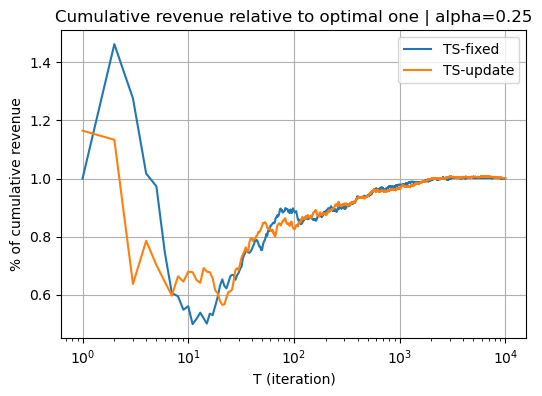

In [10]:
# Visualize the performance.
x_iter = np.arange(num_iter) + 1
plt.figure(figsize=(6,4))
plt.plot(x_iter, ts_fixed / optimal_fixed, label="TS-fixed")
plt.plot(x_iter, ts_update / optimal_update, label="TS-update")
plt.xscale("log")
plt.title(f"Cumulative revenue relative to optimal one | alpha={alpha}")
plt.xlabel("T (iteration)")
plt.ylabel("% of cumulative revenue")
plt.grid()
plt.legend()
plt.show()

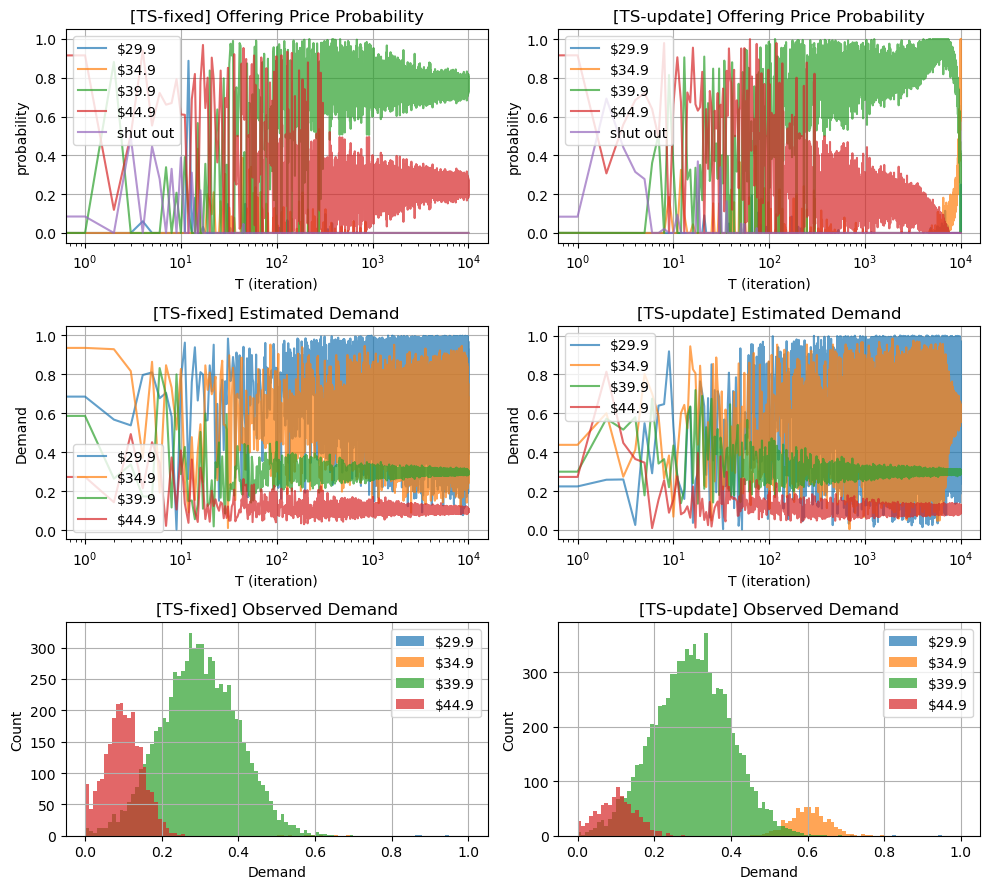

In [11]:
# Create visualization to better understand the learning process.

plt.figure(figsize=(10, 9))

plt.subplot(3, 2, 1)
lp_prob_fixed = np.array(hist_fixed["prob"])
for i in range(len(price)):
    plt.plot(lp_prob_fixed[:, i], label=f"${price[i]}", alpha=0.7)
plt.plot(lp_prob_fixed[:, -1], label="shut out", alpha=0.7)
plt.xscale("log")
plt.legend()
plt.grid()
plt.title("[TS-fixed] Offering Price Probability")
plt.xlabel("T (iteration)")
plt.ylabel("probability")

plt.subplot(3, 2, 2)
lp_prob_update = np.array(hist_update["prob"])
for i in range(len(price)):
    plt.plot(lp_prob_update[:, i], label=f"${price[i]}", alpha=0.7)
plt.plot(lp_prob_update[:, -1], label="shut out", alpha=0.7)
plt.xscale("log")
plt.legend()
plt.grid()
plt.title("[TS-update] Offering Price Probability")
plt.xlabel("T (iteration)")
plt.ylabel("probability")

plt.subplot(3, 2, 3)
d_est_fixed = np.array(hist_fixed["demand_estimate"])
for i in range(len(price)):
    plt.plot(d_est_fixed[:, i], label=f"${price[i]}", alpha=0.7)
plt.xscale("log")
plt.legend()
plt.grid()
plt.title("[TS-fixed] Estimated Demand")
plt.xlabel("T (iteration)")
plt.ylabel("Demand")

plt.subplot(3, 2, 4)
d_est_update = np.array(hist_update["demand_estimate"])
for i in range(len(price)):
    plt.plot(d_est_update[:, i], label=f"${price[i]}", alpha=0.7)
plt.xscale("log")
plt.legend()
plt.grid()
plt.title("[TS-update] Estimated Demand")
plt.xlabel("T (iteration)")
plt.ylabel("Demand")

plt.subplot(3, 2, 5)
observed_demand_fixed = np.array(hist_fixed["demand"])
price_choice_fixed = np.array(hist_fixed["price"])
for i in range(len(price)):
    plt.hist(observed_demand_fixed[price_choice_fixed == i], bins=100, 
             range=(0.0, 1.0), alpha=0.7, label=f"${price[i]}")
plt.legend()
plt.grid()
plt.title("[TS-fixed] Observed Demand")
plt.xlabel("Demand")
plt.ylabel("Count")

plt.subplot(3, 2, 6)
observed_demand_update = np.array(hist_update["demand"])
price_choice_update = np.array(hist_update["price"])
for i in range(len(price)):
    plt.hist(observed_demand_update[price_choice_update == i], bins=100, 
             range=(0.0, 1.0), alpha=0.7, label=f"${price[i]}")
plt.legend()
plt.grid()
plt.title("[TS-update] Observed Demand")
plt.xlabel("Demand")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

## Observations
In TS-fixed, the offering price probability converges through iterations, and it looks like learning the true demand distribution in the first 1000 iterations. At the same time, estimated demand for price \\$39.9 and \\$44.9 also converges while the ones for other prices shows high variance even after the simulation is done. This is consistent with the fact that the more we choose a certain price, the better we can estimate its demand distribution. As the prices \\$29.9 and \\$34.9 are rarely chosen, our estimations haven't been improved. <br>
TS-update shows similar behavior except for it started to choose \\$34.9 as the simulation approached to the end. The cell below shows the change of the inventory constraint. Following the update rule, the denominator decreases quickly toward the end of the simulation, resulting in having a looser constraint. This affects the optimal strategy -- the probability distribution that the LP provides.

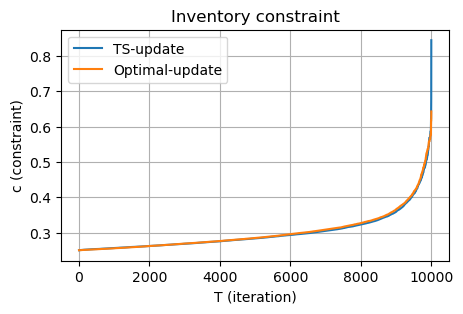

In [12]:
plt.figure(figsize=(5, 3))
plt.plot(x_iter, hist_update["constraint"], label="TS-update")
plt.plot(x_iter, hist_opt_update["constraint"], label="Optimal-update")
plt.grid()
plt.legend()
plt.title("Inventory constraint")
plt.xlabel("T (iteration)")
plt.ylabel("c (constraint)")
plt.show()

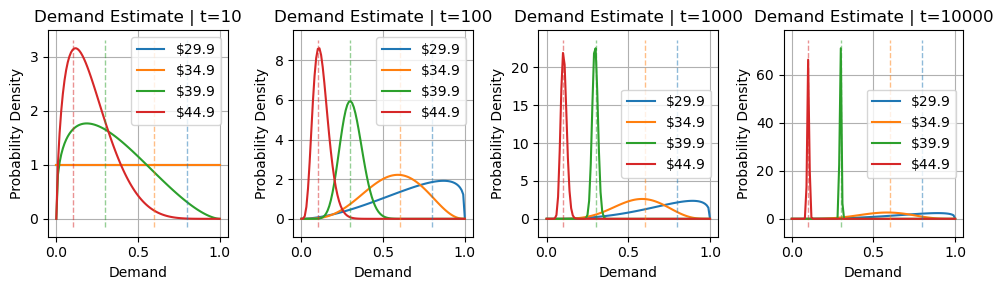

In [13]:
# One step further to visualize the parameter updates of the TS-fixed algorithm.
# The more we play a certain price, the more accurate the estimated demand distributions become
# which actually converge to the mean demand.

x = np.linspace(0, 1, 101)
checkpoint = [10, 100, 1000, 10000]
plt.figure(figsize=(10, 3))
for j in range(len(checkpoint)):
    plt.subplot(1, 4, j + 1)
    for i in range(len(price)):
        pdf = beta.pdf(x, W_store[j][i] + 1, N_store[j][i] - W_store[j][i] + 1)
        plt.plot(x, pdf, label=f"${price[i]}")
    ylim = plt.gca().get_ylim()
    for i in range(len(price)):
        plt.plot((mean_demand[i], mean_demand[i]), ylim, linestyle="dashed", 
                 color=plt.cm.tab10(i), linewidth=1, alpha=0.5)
    plt.grid()
    plt.legend()
    plt.title(f"Demand Estimate | t={checkpoint[j]}")
    plt.xlabel("Demand")
    plt.ylabel("Probability Density")
plt.tight_layout()
plt.show()

## Choice of Price to Offer
Here, I only consider the fixed inventory setting. In TS-fixed algorithm, we pick the price according to the probability produced by the LP -- the optimal mixed strategy. I first investigate the performance where we choose the offering price deterministically by simply choosing a certain in all iterations, and compare them with the performance of the optimal TS-fixed. Then, I implement $\epsilon$-greedy algorithm and evaluate the performance relative to the optimal TS-fixed.

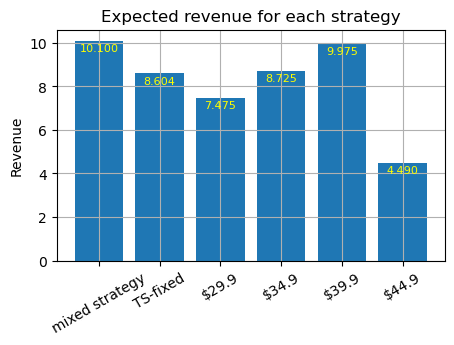

In [14]:
labels = ["mixed strategy", "TS-fixed", "$29.9", "$34.9", "$39.9", "$44.9"]
revenue = []

# Consider the case where c_j=0.25.
alpha = 0.25
profit, x = LPSolver(price, mean_demand, a, alpha)
revenue.append(profit)
revenue.append(np.dot(x[:-1] * price, np.clip(mean_demand, 0, alpha)))

for i in range(len(price)):
    revenue.append(min(alpha, mean_demand[i]) * price[i])

plt.figure(figsize=(5, 3))
plt.bar(labels, revenue)
plt.xticks(rotation=30)
plt.grid()
for i in range(len(labels)):
    plt.text(i, revenue[i] - 0.5, f"{revenue[i]:.3f}", fontsize=8, ha="center", color="yellow")
plt.title("Expected revenue for each strategy")
plt.ylabel("Revenue")
plt.show()

As expected, the mixed strategy attains the best revenue of \\$10.1 while the revenue is \\$8.604 for the optimal TS-fixed where we know the mean demand, or we assume the demand is already learned. Offering \\$39.9 all the time yields \\$9.975 in each period. Though it falls short of the mixed strategy but is better than the TS-fixed.
<br>
This suggests that an $\epsilon$-greedy type algorithm could be better than the TS-fixed if we choose the value for $\epsilon$ carefully.
## $\epsilon$-greedy
For $t = 1, \cdots, T$:
* Estimate the revenue for each price by taking the average of observed revenue for the price in the history.
* With probability $\epsilon$, choose the price uniformly at random.
* With the complementary probability $1-\epsilon$, choose the best price that maximizes the estimated revenue.
* Make $\epsilon$ smaller by the decay factor.

In [15]:
# Epsilon-greedy algorithm.

# Set the initial epsilon and decay factor.
eps = 1.0
decay = 0.9

hist_greed = {"revenue": [], "revenue_est": []}
num_iter = 10000

# Storing the average revenue observed.
revenue_est = np.zeros(5)
# To update the average, we also need to keep track of how many times we offer the price.
counter = np.zeros(5)

for i in tqdm(range(num_iter)):
    if np.random.uniform() < eps:
        # Choose a price uniformly at random.
        choice = np.random.randint(len(price) + 1)
    else:
        # Choose the best price.
        choice = np.argmax(revenue_est)
    if choice == len(price):
        D = 0
        R = 0
    else:
        D = np.clip(np.random.normal(mean_demand[choice], sigma[choice]), a_min=0.0, a_max=1.0)
        R = min(a[choice]*D, alpha) * price[choice]
    revenue_est[choice] = (revenue_est[choice] * counter[choice] + R) / (counter[choice] + 1)
    counter[choice] = counter[choice] + 1
    hist_greed["revenue"].append(R)
    hist_greed["revenue_est"].append(revenue_est.copy())
    # Update the epsilon value.
    eps = eps * decay

  0%|          | 0/10000 [00:00<?, ?it/s]

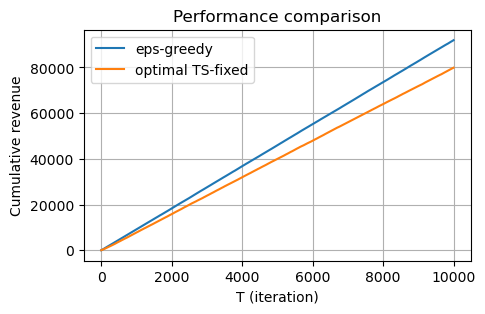

In [16]:
plt.figure(figsize=(5, 3))
plt.plot(x_iter, np.cumsum(np.array(hist_greed["revenue"])), label="eps-greedy")
plt.plot(x_iter, np.cumsum(np.array(hist_fixed["revenue"])), label="optimal TS-fixed")
plt.grid()
plt.legend()
plt.title("Performance comparison")
plt.xlabel("T (iteration)")
plt.ylabel("Cumulative revenue")
plt.show()

For a particular choice of parameters, the $\epsilon$-greedy beats the TS-fixed. Note that this simulation might be unfair -- the $\epsilon$-greedy estimates the revenue while the TS-fixed estimates the demand. The revenue estimation can be seen as the demand estimation with understanding of the inventory constraint.